# Exploration of ExTRI2 results

This notebook aims to be a visual representation of ExTRI2.

In [49]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('ExTRI2_results_exploration.ipynb')

<h3>Table of contents</h3>


[Exploration of ExTRI2 results](#Exploration-of-ExTRI2-results)
- [Setup & configuration](#Setup-&-configuration)
- [General analytics](#General-analytics)
- [Validation](#Validation)

## Setup & configuration
Definition of all paths, variables, and functions that will be used throughout the notebook.

In [2]:
# IMPORTS
import sys
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import upsetplot
from analysis import *

sys.path.append('../scripts/common')
from notebook_utils import table_from_dict, h3, h4, h5, md
pd.set_option('display.max_colwidth', 20)

In [3]:
# LOAD CONFIG & DFs
config = load_config()

# Load datasets
f_ExTRI2  = pd.read_csv(config['final_ExTRI2_p'], sep='\t', header=0, dtype=str)
val_sents = pd.read_csv(config['validated_sents_p'], sep='\t', header=0, dtype=str)

# Preprocessing
f_ExTRI2['PMID+Sent'] = f_ExTRI2['#SentenceID'].apply(lambda row: row.split(':')[1]+'|'+row.split(':')[4])
f_ExTRI2['PMID+Sent+TRI'] = f_ExTRI2['PMID+Sent'] + '|' + f_ExTRI2['TF'] + '|' + f_ExTRI2['TG']
f_ExTRI2['TRI Id'] = f_ExTRI2['TF Id'] + '|' + f_ExTRI2['TG Id']
f_ExTRI2['PMID+Sent+TRI_Id'] = f_ExTRI2['PMID+Sent'] + '|' + f_ExTRI2['TRI Id']


In [4]:
# TODO - ERASE if all this code is useless 

# def get_taxID_TF_sets(TF_set, annotations_summary):
#     ''''''
#     taxID_TF_sets = {'9606': set(), '10116': set(), '10090': set()}
#     for id, ann in zip(TF_set, annotations_summary):
#         symbol = ann['Name']
#         TaxID = ann['Organism']['TaxID']
#         taxID_TF_sets[TaxID].add(id)

#     return taxID_TF_sets

# def retrieve_annotations_entrez(id_list):
#     """Annotates Entrez Gene IDs using Bio.Entrez, in particular epost (to
#     submit the data to NCBI) and esummary to retrieve the information.
#     Returns a list of dictionaries with the annotations."""

#     request = Entrez.epost("gene", id=",".join(id_list))
#     result = Entrez.read(request)
#     webEnv = result["WebEnv"]
#     queryKey = result["QueryKey"]
#     data = Entrez.esummary(db="gene", webenv=webEnv, query_key=queryKey)
#     annotations = Entrez.read(data)
#     annotationsSummary = annotations['DocumentSummarySet']['DocumentSummary']

#     assert len(id_list) == len(annotationsSummary), f"id_list and annotationsSummary are of different length: {len(id_list)} != {len(annotationsSummary)}"

#     return annotationsSummary

# def get_symbol_to_id_map(TF_set, annotations_summary):
#     '''Make map from symbol/TaxID to Gene ID'''
#     symbol_to_id_map = {'9606': {}, '10116': {}, '10090': {}}
#     for id, ann in zip(TF_set, annotations_summary):
#         symbol = ann['Name']
#         TaxID = ann['Organism']['TaxID']
#         symbol_to_id_map[TaxID].setdefault(symbol, []).append(id)
    
#     return symbol_to_id_map

# # # Load dbTF & coTF sets
# dbTF_set = load_TF_set(dbTFs_path)
# annotations_summary = retrieve_annotations_entrez(dbTF_set)
# dbTF_symbol_to_ID_map = get_symbol_to_id_map(dbTF_set, annotations_summary)
# dbTF_taxID_sets = get_taxID_TF_sets(dbTF_set, annotations_summary)
# print('dbTF sets obtained')
# time.sleep(3)
# coTF_set = load_TF_set(coTFs_path)
# annotations_summary = retrieve_annotations_entrez(coTF_set)
# coTF_symbol_to_ID_map = get_symbol_to_id_map(coTF_set, annotations_summary)
# coTF_taxID_sets = get_taxID_TF_sets(coTF_set, annotations_summary)
# print('coTF sets obtained')

In [13]:
# TODO - Send it to Astrid after I have revised them a little bit myself
# TODO - See what is the following word and how many have a + afterwards (also lower() gives more maybe??)
m = f_ExTRI2['TG'].str.upper().str.contains('CD')
f_ExTRI2[m][['TG', 'TG Symbol', 'Sentence']]

In [6]:
# TODO - Give them to Astrid and see if we should just get rid of them
m = f_ExTRI2['TG'] == 'of'
m |= f_ExTRI2['TF'] == 'of'
f_ExTRI2[m].to_excel("ERASE_of.xlsx")


In [17]:
(f_ExTRI2['TF'].str.upper() == 'OF').sum()


np.int64(603)

## General analytics

In [39]:
def print_analytics(analytics):
    for key, value in analytics.items():
        if type(value) is set:
            num = len(value)
        else:
            num = value
        print(f"{key:<17}{num:>17,}")

def get_analytics(df) -> dict:
    h3("General analytics")
    analytics = {}
    analytics['Num sents']      = len(df)
    #analytics['Num blank TG Id']  = len(df[(df['TG Id'] == '') | (df['TG Id'] == 'None') | (df['TG Id'] == 'nan')])
    #analytics['Num mutated TF']   = (df['Mutated_TF'] == 'True').sum()
    analytics['Uniq PMIDs']     = set(df['PMID'])
    analytics['Uniq sent-TRI']  = set(df['PMID+Sent+TRI'])
    analytics['Uniq sent-TRI Id'] = set(df['PMID+Sent+TRI_Id'])
    analytics['Uniq TRI Id']    = set(df['TRI Id'])
    analytics['Uniq TF Id']     = set(df['TF Id'])
    analytics['Uniq TG Id']     = set(df['TG Id'])
    analytics['Human TF Id']    = set(df[df['TF TaxID'] == '9606']['TF Id'])
    analytics['Human TG Id']    = set(df[df['TG TaxID'] == '9606']['TG Id'])
    analytics['Human TF Id 2']  = set(df[df['TF TaxID'].str.contains('9606')]['TF Id'])
    analytics['Human TG Id 2']  = set(df[df['TG TaxID'].str.contains('9606')]['TG Id'])

    return analytics

def show_analytics(label, num, total):
    total_len = total if type(total) is int else len(total)
    num_len = num if type(num) in (int, np.int64) else len(num)
    print(f'{label:30}{num_len:,}/{total_len:<10,}{num_len/total_len:>10.2%}')

def display_uniques():
    h3("Unique values")
    m_cols = ['#SentenceID', 'Sentence', 'PMID', 'TRI Id', 'PMID+Sent', 'PMID+Sent+TRI', 'PMID+Sent+TRI_Id', '',
            'Valid', 'MoR', 'TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes', 'Mutated_TF']

    total = len(f_ExTRI2)
    for col in m_cols:
        if col == '':
            print()
            continue
        num = f_ExTRI2[col].unique()
        show_analytics(f'Unique {col}', num, total)

def display_NA_values():
    h3("Columns with Na values")
    cols_to_ignore = ['Mutated Genes', 'Mutation offsets', 'tags']

    total = len(f_ExTRI2)
    for col in f_ExTRI2.columns:
        col_has_na = int(f_ExTRI2[col].isna().sum())
        if col_has_na & (col not in cols_to_ignore):
            show_analytics(f'{col}', col_has_na, total)

def display_cols_with_colons():
    h3("Columns with colons (;)")
    colon_cols = ['TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes']

    total = len(f_ExTRI2)
    for col in colon_cols:
        if col == '':
            print()
            continue
        num = int(f_ExTRI2[col].str.contains(';').sum())
        show_analytics(f'{col}', num, total)


    h3("Number of unique rows with ;")
    for col in colon_cols:
        if col == '':
            print()
            continue
        if f_ExTRI2[col].isna().sum() != 0:
            continue
        m = f_ExTRI2[col].str.contains(';')
        num = f_ExTRI2[m][col].unique()
        num_un = f_ExTRI2[col].unique()
        show_analytics(f'{col}', num, num_un)

def display_TF_types():
    h3("Joined TF Types")
    squished = f_ExTRI2['TF_type'].apply(lambda x: ";".join(set(x.split(';'))))
    print(squished.value_counts())
    print()

def display_unique_content_per_col():
    h3("Columns with <30 unique values")
    for col in f_ExTRI2.columns:
        uniq = f_ExTRI2[col].unique()
        if len(uniq) < 30:
            print(f"{col:25}{len(uniq):<10}{', '.join(uniq.astype(str))}")
        # else:
        #     print(f"{col:25}{len(uniq):<10}{', '.join(uniq[:2])}")


# TODO - Understand why there are Na values in hgnc & entrez_gene columns
print_analytics(get_analytics(f_ExTRI2))
display_uniques()
display_NA_values()
display_cols_with_colons()
display_TF_types()
display_unique_content_per_col()

<h3>General analytics</h3>

Num sents                  879,087
Uniq PMIDs                 311,466
Uniq sent-TRI              877,703
Uniq sent-TRI Id           878,876
Uniq TRI Id                288,520
Uniq TF Id                   7,265
Uniq TG Id                  26,097
Human TF Id                  2,784
Human TG Id                 12,480
Human TF Id 2                3,510
Human TG Id 2               13,704


<h3>Unique values</h3>

Unique #SentenceID            879,087/879,087      100.00%
Unique Sentence               877,786/879,087       99.85%
Unique PMID                   311,466/879,087       35.43%
Unique TRI Id                 288,520/879,087       32.82%
Unique PMID+Sent              569,443/879,087       64.78%
Unique PMID+Sent+TRI          877,703/879,087       99.84%
Unique PMID+Sent+TRI_Id       878,876/879,087       99.98%

Unique Valid                  1/879,087        0.00%
Unique MoR                    3/879,087        0.00%
Unique TF_type                78/879,087        0.01%
Unique TF TaxID               20/879,087        0.00%
Unique TG TaxID               22/879,087        0.00%

Unique TF                     24,948/879,087        2.84%
Unique TF Id                  7,265/879,087        0.83%
Unique TF Symbol              6,205/879,087        0.71%
Unique TF_human_entrez_gene   4,841/879,087        0.55%
Unique TF_hgnc_id             4,838/879,087        0.55%
Unique TF_human_symbol        4

<h3>Columns with Na values</h3>

TF_human_entrez_gene          33/879,087        0.00%
TF_hgnc_id                    33/879,087        0.00%
TF_human_symbol               33/879,087        0.00%


<h3>Columns with colons (;)</h3>

TF_type                       16,662/879,087        1.90%
TF TaxID                      16,662/879,087        1.90%
TG TaxID                      8,239/879,087        0.94%

TF                            68/879,087        0.01%
TF Id                         16,662/879,087        1.90%
TF Symbol                     16,662/879,087        1.90%
TF_human_entrez_gene          108,970/879,087       12.40%
TF_hgnc_id                    108,917/879,087       12.39%
TF_human_symbol               108,917/879,087       12.39%

TG                            8/879,087        0.00%
TG Id                         8,239/879,087        0.94%
TG Symbol                     8,239/879,087        0.94%
TG_human_entrez_gene          91,550/879,087       10.41%
TG_hgnc_id                    91,515/879,087       10.41%
TG_human_symbol               91,514/879,087       10.41%
Mutated Genes                 2,111/879,087        0.24%


<h3>Number of unique rows with ;</h3>

TF_type                       75/78            96.15%
TF TaxID                      17/20            85.00%
TG TaxID                      19/22            86.36%

TF                            42/24,948         0.17%
TF Id                         1,207/7,265         16.61%
TF Symbol                     1,147/6,205         18.49%

TG                            8/56,785         0.01%
TG Id                         1,970/26,097         7.55%
TG Symbol                     1,907/23,132         8.24%


<h3>Joined TF Types</h3>

TF_type
dbTF            450842
ll_coTF         228021
coTF            197560
ll_coTF;-         1090
coTF;-             738
coTF;dbTF          553
-;dbTF             257
coTF;-;dbTF         13
ll_coTF;dbTF         7
ll_coTF;coTF         6
Name: count, dtype: int64



<h3>Columns with <30 unique values</h3>

Valid                    1         Valid
MoR                      3         UNDEFINED, ACTIVATION, REPRESSION
Mutated_TF               2         False, True
TF TaxID                 20        9606, 10090, 10116, 9606;9606, 10090;10090, 9606;9606;9606, 10116;10116, 9606;9606;9606;9606, 10090;10090;10090, 10116;10116;10116, 9606;9606;9606;9606;9606;9606, 10090;10090;10090;10090, 10116;10116;10116;10116, 9606;9606;9606;9606;9606;9606;9606;9606, 9606;9606;9606;9606;9606, 10090;10090;10090;10090;10090;10090;10090, 10090;10090;10090;10090;10090;10090, 10090;10090;10090;10090;10090, 9606;9606;9606;9606;9606;9606;9606, 9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606
TG TaxID                 22        9606, 9606;9606, 10090, 10116, 10090;10090, 9606;9606;9606, 10116;10116;10116, 10116;10116, 10090;10090;10090, 9606;9606;9606;9606, 10090;10090;10090;10090;10090, 9606;9606;9606;9606;9606;9606, 10090;10090;10090;10090, 10116;10116;10116;10116, 9606;9606;9606;9606;96

In [40]:
# TODO - Investigations to do:
# How many rows w/ +1 value? How to solve?
# How many TFs have we retrieved?
# NTNU - Something with that??

# Validation : copy the graph here (so they see everything in 1 only place)

In [41]:
# Human TF analytics
m_human = f_ExTRI2['TF TaxID'].str.contains('9606') & f_ExTRI2['TG TaxID'].str.contains('9606')
f_ExTRI2_human = f_ExTRI2[m_human]

In [1]:
Ex

NameError: name 'f_ExTRI' is not defined

## Validation

In [ ]:
# TODO - Centralise all validation analysis in one only place
# TODO - Astrid considered "Negation" as positive. I should change this in validation.
# TODO - Get the set of PPIs

In [ ]:
def show_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame):
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_balanced, 'Balanced', "blue", 1),
        (val_random, "Randomly validated", "green", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_ylabel(f"Number of Sentences with that {tf_type}")
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,30))
    ax.legend()

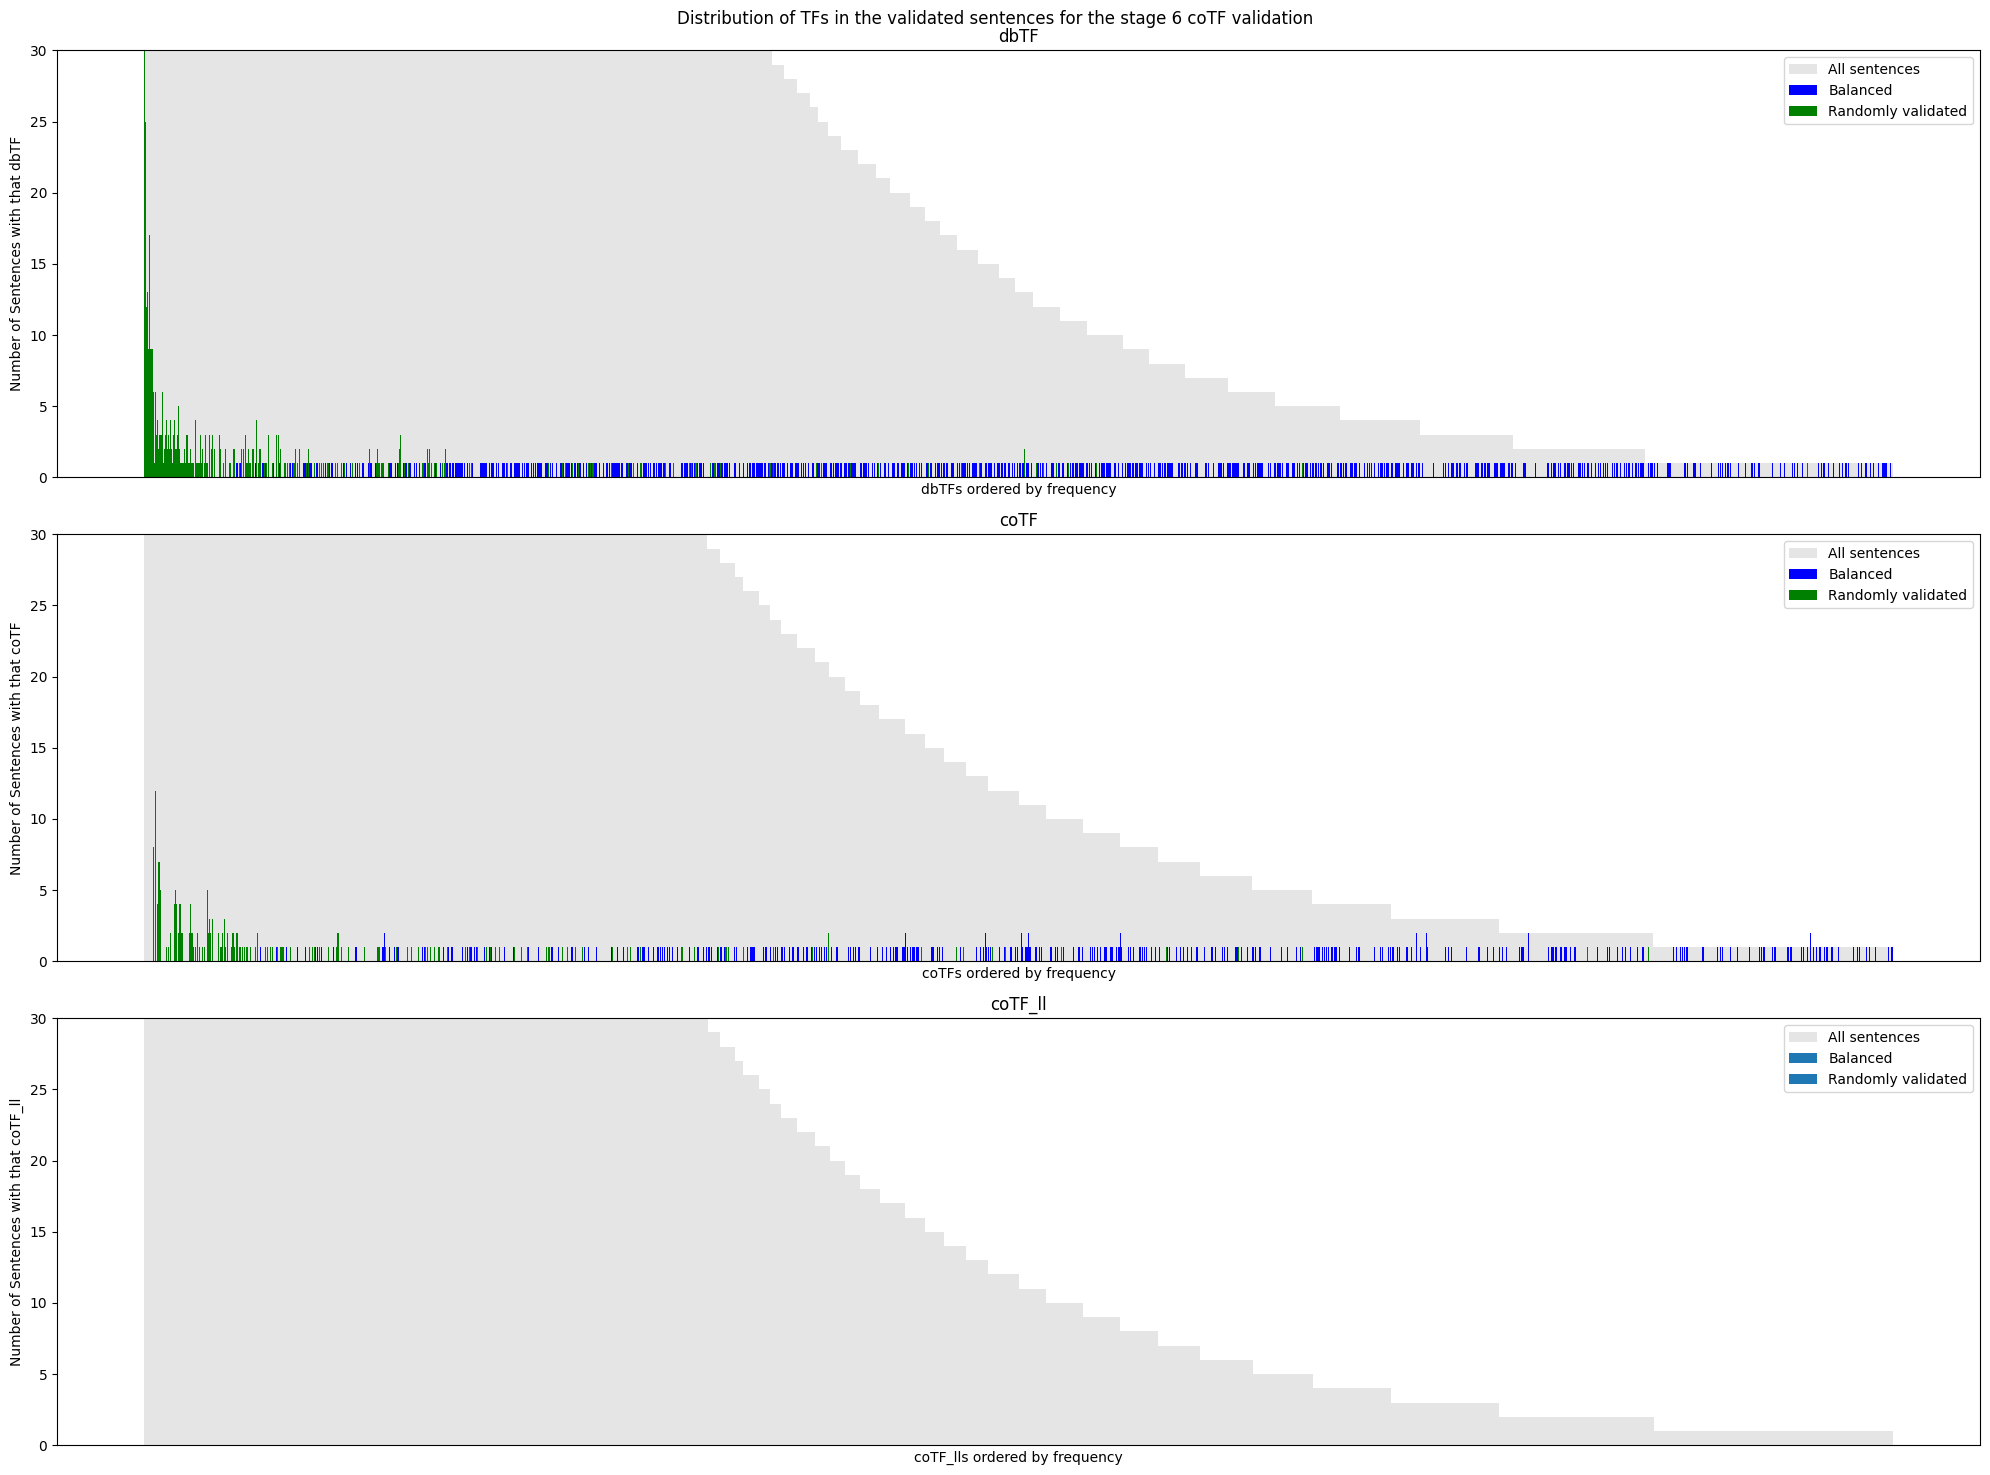

In [42]:
# Get valid & validated datasets
valid_dbTF = f_ExTRI2[f_ExTRI2['TF_type'].str.contains('dbTF')]
valid_coTF = f_ExTRI2[(f_ExTRI2['TF_type'].str.contains('coTF')) & (~f_ExTRI2['TF_type'].str.contains('dbTF'))]


dbTF_val_b = val_sents[(val_sents['TF_type'] == 'dbTF') & (val_sents['method'] == 'balanced')]
dbTF_val_r = val_sents[(val_sents['TF_type'] == 'dbTF') & (val_sents['method'] == 'random')]
coTF_val_b = val_sents[(val_sents['TF_type'] == 'coTF') & (val_sents['method'] == 'balanced')]
coTF_val_r = val_sents[(val_sents['TF_type'] == 'coTF') & (val_sents['method'] == 'random')]
coTF_ll_val_b = val_sents[(val_sents['TF_type'] == 'll_coTF') & (val_sents['method'] == 'balanced')]
coTF_ll_val_r = val_sents[(val_sents['TF_type'] == 'll_coTF') & (val_sents['method'] == 'random')]


# Plot
fig, axes = plt.subplots(3, 1, figsize=(20, 15))
show_validation_distribution(axes[0], 'dbTF', valid_dbTF, val_balanced = dbTF_val_b, val_random = dbTF_val_r)
show_validation_distribution(axes[1], 'coTF', valid_coTF, val_balanced = coTF_val_b, val_random = coTF_val_r)
show_validation_distribution(axes[2], 'coTF_ll', valid_coTF, val_balanced = coTF_ll_val_b, val_random = coTF_ll_val_r)

plt.suptitle("Distribution of TFs in the validated sentences for the stage 6 coTF validation")
plt.tight_layout()
plt.show()

In [43]:
# Analytics
# TODO - Balanced doesn't include its portion in the ranodm ones. I must add it or find a way to adding it.

def display_dict(analysis_dict: dict, columns=["Correct", "Total"]):
    """
    Input format: dict(list[:2]) where list[0] is a subset of list[1].
    Displays the dict and the percentage between list[0]/list[1]
    TODO - Is this a correct docstring? Improve w/ChatGPT
    """
    df = pd.DataFrame.from_dict(analysis_dict, orient="index", columns=columns)
    df['perc'] = df['Correct'] / df['Total'] * 100
    display(df)

labels = ["dbTF random", "dbTF balanced", "coTF random", "coTF balanced", "coTF ll random", "coTF ll balanced"]
dfs    = [dbTF_val_r, dbTF_val_b, coTF_val_r, coTF_val_b, coTF_ll_val_r, coTF_ll_val_b]

h3("TRI + MoR")
display_dict({label: [(df['Valid?'] == 'T').sum(), len(df)] for label, df in zip(labels, dfs)})

h3("TRI")
display_dict({label: [(~((df['Valid?'] == 'F') & (df['true_label'] != df['Label']))).sum(), 
                      len(df)] for label, df in zip(labels, dfs)})

h3("MoR")
def get_correct_total_MoR(df):
    total = (~((df['Valid?'] == 'F') & (df['true_label'] != df['Label']))).sum()
    incorrect = ((df['Valid?'] == 'F') & (df['true_label'] == df['Label']) & (df['Label'] == "TRUE")).sum()
    return (total - incorrect, total)
display_dict({label: get_correct_total_MoR(df) for label, df in zip(labels, dfs)})

h3("Norm/NER")
display_dict({label: [(df['TF_is_incorrect'].isna() & df['TF_is_incorrect'].isna()).sum(), len(df)] for label, df in zip(labels, dfs)})
# TODO - I don't believe the Norm/NER results. Check if that's biased due to NFKB still marked as unvalid

md("Isues in all sentences")
display(val_sents['Other issues'].value_counts())
print(len(val_sents))

md("Issues in unvalid sentences")
display(val_sents[val_sents['Valid?'] == 'F']['Other issues'].value_counts())
print(len(val_sents[val_sents['Valid?'] == 'F']))

md("Issues in unvalid dbTFsentences")
display(val_sents[(val_sents['Valid?'] == 'F') & (val_sents['TF_type'] == 'dbTF')]['Other issues'].value_counts())
print("Num invalid: ", len(val_sents[(val_sents['Valid?'] == 'F') & (val_sents['TF_type'] == 'dbTF')]))
print("Num dbTF: ", len(val_sents[(val_sents['TF_type'] == 'dbTF')]))


<h3>TRI + MoR</h3>

,Correct,Total,perc
dbTF random,735,869,84.579977
dbTF balanced,1226,1396,87.822350
coTF random,311,499,62.324649
coTF balanced,572,802,71.321696
coTF ll random,0,0,NaN
coTF ll balanced,0,0,NaN


<h3>TRI</h3>

,Correct,Total,perc
dbTF random,805,869,92.635213
dbTF balanced,1247,1396,89.326648
coTF random,323,499,64.729459
coTF balanced,586,802,73.067332
coTF ll random,0,0,NaN
coTF ll balanced,0,0,NaN


<h3>MoR</h3>

,Correct,Total,perc
dbTF random,735,805,91.304348
dbTF balanced,1226,1247,98.315958
coTF random,311,323,96.284830
coTF balanced,572,586,97.610922
coTF ll random,0,0,NaN
coTF ll balanced,0,0,NaN


<h3>Norm/NER</h3>

,Correct,Total,perc
dbTF random,859,869,98.849252
dbTF balanced,1376,1396,98.567335
coTF random,490,499,98.196393
coTF balanced,782,802,97.506234
coTF ll random,0,0,NaN
coTF ll balanced,0,0,NaN


Isues in all sentences

Other issues
mutation             930
PPI                  413
Splitter              40
negation              21
mutation;negation     17
Splitter;mutation      4
suboptimal             4
PPI;Splitter           3
PPI;suboptimal         1
PPI;negation           1
Name: count, dtype: int64

4927


Issues in unvalid sentences

Other issues
PPI                  413
mutation              55
Splitter              19
suboptimal             4
mutation;negation      3
PPI;Splitter           3
negation               2
PPI;suboptimal         1
PPI;negation           1
Name: count, dtype: int64

1095


Issues in unvalid dbTFsentences

Other issues
PPI                  49
mutation             29
Splitter             11
suboptimal            4
mutation;negation     3
PPI;Splitter          1
Name: count, dtype: int64

Num invalid:  304
Num dbTF:  2265


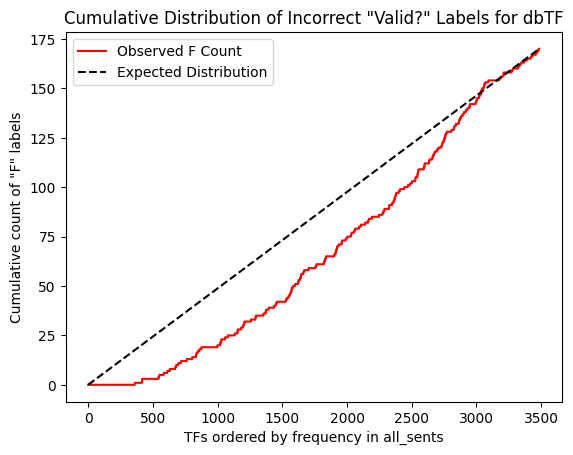

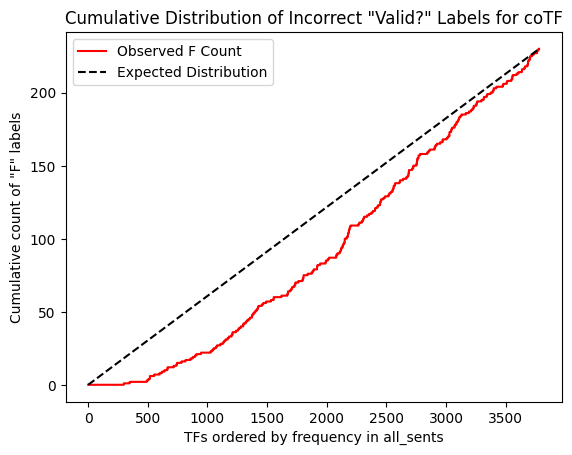

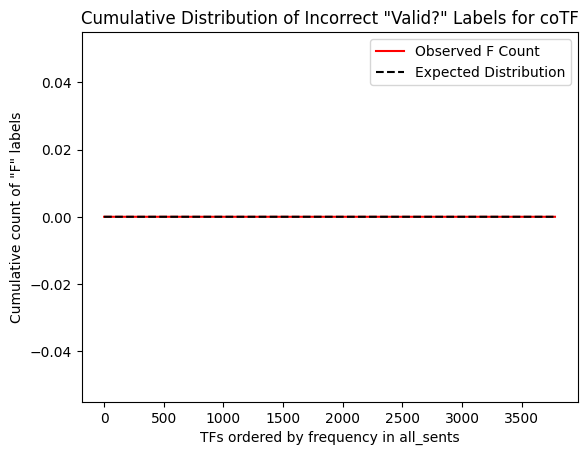

In [44]:
# ChatGPT's plot. let's see
def plot_false_validation_distribution(tf_type: str, all_sents: pd.DataFrame, val_balanced: pd.DataFrame):
    # Step 1: Count TF frequency in all_sents and sort them
    tf_counts = all_sents['TF Id'].value_counts().sort_values(ascending=False)
    
    # Step 2: Filter sentences in val_balanced with 'Valid?' == 'F'
    val_false = val_balanced[val_balanced['Valid?'] == 'F']
    
    # Step 3: Count 'F's for each TF in val_balanced
    val_false_counts = val_false['TF Id'].value_counts().reindex(tf_counts.index, fill_value=0)
    
    # Step 4: Calculate the cumulative sum of 'F's
    cumulative_f_counts = val_false_counts.cumsum()
    
    # Step 5: Plot the cumulative sum of 'F's
    fig, ax = plt.subplots()
    ax.step(range(len(cumulative_f_counts)), cumulative_f_counts, where='mid', label='Observed F Count', color='red')
    
    # Step 6: Plot the expected line
    total_f_count = val_false_counts.sum()
    ax.plot(range(len(cumulative_f_counts)), [total_f_count * (i / len(cumulative_f_counts)) for i in range(len(cumulative_f_counts))], label='Expected Distribution', linestyle='--', color='black')
    
    # Step 7: Customize plot
    ax.set_title(f'Cumulative Distribution of Incorrect "Valid?" Labels for {tf_type}')
    ax.set_xlabel('TFs ordered by frequency in all_sents')
    ax.set_ylabel('Cumulative count of "F" labels')
    ax.legend()
    plt.show()

# Example call
plot_false_validation_distribution('dbTF', valid_dbTF, dbTF_val_b)
plot_false_validation_distribution('coTF', valid_coTF, coTF_val_b)
plot_false_validation_distribution('coTF', valid_coTF, coTF_ll_val_b)
